In [1]:
# 需要用到的包
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator

plt.rcParams['font.sans-serif'] = ['SimHei']  ###防止无法显示中文并设置黑体
plt.rcParams['axes.unicode_minus'] = False  ###用来正常显示负号

In [2]:
rain = xr.open_dataset('data\\CN05.1_Pre_1961_2017_month_025x025.nc')['pre']
rain = rain.loc[rain.time.dt.month.isin([6, 7, 8])].loc[:, 26:33, 106:122]
rain = rain.groupby(rain.time.dt.year).mean(dim='time')
rain = rain * 92
rain

<xarray.DataArray 'pre' (year: 56, lat: 29, lon: 65)>
array([[[ 565.7156 ,  495.15598,  471.00815, ...,        nan,
                nan,        nan],
        [ 526.20874,  463.16556,  419.1885 , ...,        nan,
                nan,        nan],
        [ 485.5093 ,  422.86063,  360.48846, ...,        nan,
                nan,        nan],
        ...,
        [ 927.5284 ,  796.25165,  783.7989 , ...,        nan,
                nan,        nan],
        [ 921.5262 ,  820.11584,  798.51184, ...,        nan,
                nan,        nan],
        [ 772.6701 ,  814.7526 ,  734.5804 , ...,        nan,
                nan,        nan]],

       [[ 565.54504,  540.2187 ,  566.9998 , ...,        nan,
                nan,        nan],
        [ 536.631  ,  525.22046,  493.80664, ...,        nan,
                nan,        nan],
        [ 512.51996,  515.54517,  509.23154, ...,        nan,
                nan,        nan],
...
        [ 700.82446,  677.18896,  663.2068 , ...,        nan,
                nan,        nan],
        [ 620.47705,  618.12463,  611.3699 , ...,        nan,
                nan,        nan],
        [ 510.42694,  533.86566,  535.6796 , ...,        nan,
                nan,        nan]],

       [[ 615.21045,  590.4197 ,  539.86475, ...,        nan,
                nan,        nan],
        [ 605.4814 ,  559.6482 ,  506.38144, ...,        nan,
                nan,        nan],
        [ 586.1322 ,  498.5821 ,  482.23874, ...,        nan,
                nan,        nan],
        ...,
        [ 457.47565,  419.9706 ,  426.3118 , ...,        nan,
                nan,        nan],
        [ 409.12506,  379.74026,  382.93893, ...,        nan,
                nan,        nan],
        [ 327.25058,  312.23038,  321.9389 , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 106.0 106.2 106.5 106.8 ... 121.2 121.5 121.8 122.0
  * lat      (lat) float64 26.0 26.25 26.5 26.75 27.0 ... 32.25 32.5 32.75 33.0
  * year     (year) int64 1961 1962 1963 1964 1965 ... 2012 2013 2014 2015 2016

In [3]:
hgt = xr.open_dataset('data\\hgt.mon.mean.nc')['hgt'].loc[:, 500, :, :]
hgt = hgt.loc[hgt.time.dt.month.isin([12, 1, 2])].loc['1960-03-01':'2016-03-01':, :, :]
hgt

<xarray.DataArray 'hgt' (time: 168, lat: 73, lon: 144)>
[1766016 values with dtype=float32]
Coordinates:
    level    float32 500.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1960-12-01 1961-01-01 ... 2016-02-01
Attributes:
    long_name:     Monthly mean geopotential height
    valid_range:   [ -700. 35000.]
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Other
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [ -354.45834 32321.098  ]

In [4]:
sst = xr.open_dataset('data\\sst.mnmean.v4.nc')['sst']
sst = sst.loc[sst.time.dt.month.isin([12, 1, 2])].loc['1960-03-01':'2016-03-01', :, :]
sst

<xarray.DataArray 'sst' (time: 168, lat: 89, lon: 180)>
[2691360 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-12-01 1961-01-01 ... 2016-02-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    actual_range:  [-1.8  33.95]
    valid_range:   [-5. 40.]
    dataset:       NOAA Extended Reconstructed SST V4
    parent_stat:   Individual Values

In [5]:
# 把今年的12月和明年的1、2月当作今年的冬季
# 创建一个1961-2010的一维矩阵
def winsel(hgt500):
    winhgt500 = np.zeros((int(len(hgt500.time) / 3), len(hgt500.lat), len(hgt500.lon)))
    temp = np.zeros((len(hgt500.lat), len(hgt500.lon)))
    j = 0
    for i in range(len(hgt500.time)):
        temp += hgt500[i, :, :]
        if (i + 1) % 3 == 0:
            winhgt500[j, :, :] = temp / 3
            j += 1
            temp = 0
    # 把win转化成 DataArray
    winhgt500 = xr.DataArray(data=winhgt500, dims=['time', 'lat', 'lon'],
                             coords={'time': pd.date_range('1960', '2016', freq='1y'),
                                     'lat': hgt500.lat.data,
                                     'lon': hgt500.lon.data})
    return winhgt500

In [6]:
winhgt500 = winsel(hgt)
winsst = winsel(sst)
winsst

<xarray.DataArray (time: 56, lat: 89, lon: 180)>
array([[[-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
        [-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
        [-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
        [-1.70333326, -1.69666672, -1.68999994, ..., -1.75999987,
         -1.73000002, -1.71333325],
        [-1.67666662, -1.65666676, -1.63333333, ..., -1.71999991,
         -1.69333327, -1.6833334 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1961-12-31 ... 2015-12-31
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

# 计算长江中下游（26-33N/106-122E）1961-2016年夏季降水指数，并画出标准化的长江中下游夏季降水序列图

In [7]:
rainzhi = rain.mean(dim=['lat', 'lon'])
rainzhi

<xarray.DataArray 'pre' (year: 56)>
array([438.82404, 583.63837, 483.08777, 513.0076 , 535.3992 , 399.72733,
       453.15222, 549.24725, 659.74927, 520.82104, 450.0766 , 418.15607,
       527.55914, 521.24615, 563.11334, 475.9609 , 581.7569 , 369.30258,
       553.33704, 698.9575 , 450.12708, 629.9874 , 631.51184, 531.4543 ,
       437.77524, 505.6451 , 579.5008 , 489.67627, 560.52136, 475.50604,
       578.63654, 484.3973 , 642.1881 , 532.0575 , 604.6704 , 702.30743,
       543.22394, 711.4294 , 693.68646, 583.9099 , 484.97034, 617.08167,
       497.77444, 515.78046, 528.83954, 470.35928, 598.56   , 589.0776 ,
       516.5423 , 601.75037, 563.15356, 521.76953, 499.26273, 652.2213 ,
       682.65027, 627.58014], dtype=float32)
Coordinates:
  * year     (year) int64 1961 1962 1963 1964 1965 ... 2012 2013 2014 2015 2016

In [8]:
# 标准化
rainzhi = (rainzhi - rainzhi.mean()) / rainzhi.std()
rainzhi

<xarray.DataArray 'pre' (year: 56)>
array([-1.3586963 ,  0.46026823, -0.8027143 , -0.4269009 , -0.14564823,
       -1.849777  , -1.1787248 ,  0.02829293,  1.4162719 , -0.3287592 ,
       -1.2173566 , -1.6182997 , -0.24412419, -0.32341954,  0.20246024,
       -0.8922324 ,  0.43663573, -2.2319322 ,  0.07966333,  1.9087536 ,
       -1.2167226 ,  1.0424433 ,  1.061591  , -0.19519861, -1.3718699 ,
       -0.519379  ,  0.40829757, -0.7199583 ,  0.16990325, -0.8979458 ,
        0.3974419 , -0.7862656 ,  1.1956921 , -0.18762189,  0.72444475,
        1.9508308 , -0.04736393,  2.0654085 ,  1.8425456 ,  0.46367902,
       -0.779068  ,  0.8803384 , -0.6182399 , -0.39207235, -0.22804157,
       -0.96259254,  0.6476939 ,  0.52858835, -0.38250312,  0.687767  ,
        0.20296547, -0.31684557, -0.5995461 ,  1.3217157 ,  1.7039237 ,
        1.0122062 ], dtype=float32)
Coordinates:
  * year     (year) int64 1961 1962 1963 1964 1965 ... 2012 2013 2014 2015 2016

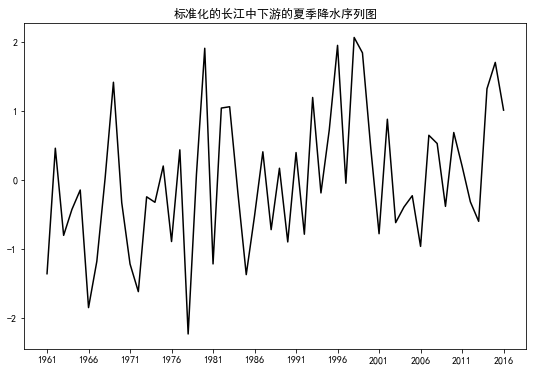

In [9]:
# 绘图
fig = plt.figure(figsize=(9, 6))
ax = fig.subplots(1, 1)
# 标题
ax.set_title('标准化的长江中下游的夏季降水序列图')

ax.plot(rainzhi.year, rainzhi.data, color="black")
ax.set_xticks(np.arange(1961, 2017, 5))

# 保存图片
plt.savefig('data\\ex7-1.png')

# 计算长江中下游夏季降水指数与前期冬季（DJF）海温场的相关系数，并画图，选出关键区，并将关键区的区域平均海温指数作为潜在预报因子

# 相关系数公式
$r=\frac{\frac{1}{n}\sum_{i=1}^{n}(X_{i}-\overline{X})(Y_{i}-\overline{Y})}{\frac{1}{n}\sqrt{\sum_{i=1}^{n}(X_{i}-\overline{X})^2}\sqrt{\sum_{i=1}^{n}(Y_{i}-\overline{Y})^2}}$

# 相关系数t检验公式
$|t|=|\frac{r\sqrt{n-2}}{\sqrt{1-r^2}}|>t_{\alpha }$

In [10]:
# 计算夏季降水指数与前期冬季500hPa高度场和海温的相关系数 （空间场）
def xiangguan(WP, ds):
    aveWP = np.mean(WP)
    x = WP - aveWP
    y = ds.loc[:, :, :] - ds.loc[:, :, :].mean(dim='time')
    x = np.array(x).reshape((len(WP), 1, 1))
    up = np.sum(x * y, axis=0) / len(WP.year)
    down = (np.sqrt(np.sum(x ** 2)) * np.sqrt(np.sum(y ** 2, axis=0))) / len(WP.year)
    # 相关系数
    r = up / down
    return r

# t检验
def tjianyan(r,n):
    return np.abs(r*np.sqrt(n-2)/np.sqrt(1-np.power(r,2)))

In [11]:
# 前期冬季海温的标准化
winsstb = (winsst - winsst.mean(dim='time')) / winsst.std(dim='time')
winsstb

d:\anaconda\envs\py310\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.DataArray (time: 56, lat: 89, lon: 180)>
array([[[-7.41619848, -7.41619848, -7.41619848, ..., -7.41619848,
         -7.41619848, -7.41619848],
        [-0.26911408, -0.29077839, -0.29548019, ..., -0.14581327,
         -0.15365623, -0.18330184],
        [-0.25492678, -0.27415196, -0.29416064, ..., -0.24247626,
         -0.26099787, -0.27142389],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.13483998,  0.13483998,  0.13483998, ...,  0.13483998,
          0.13483998,  0.13483998],
        [-0.26910627, -0.29077219, -0.29547471, ..., -0.14579081,
         -0.15364341, -0.18329164],
        [-0.25492273, -0.27414835, -0.29415764, ..., -0.24246655,
         -0.26099158, -0.27141921],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.13483998,  0.13483998,  0.13483998, ...,  0.13483998,
          0.13483998,  0.13483998],
        [ 6.06465119,  5.07923743,  4.76043254, ...,  7.39051399,
          7.37492705,  7.229859  ],
        [ 3.93714231,  4.06894222,  3.90809587, ...,  6.27505768,
          5.37392544,  4.31463183],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1961-12-31 ... 2015-12-31
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [12]:
# 夏季降水指数与前期冬季海温的相关系数
rain_sst_xg = xiangguan(rainzhi, winsstb)
rain_sst_xg

<xarray.DataArray (lat: 89, lon: 180)>
array([[0.18320658, 0.18320658, 0.18320658, ..., 0.18320658, 0.18320658,
        0.18320658],
       [0.16748788, 0.22091377, 0.23454994, ..., 0.12949658, 0.12818533,
        0.15613782],
       [0.30984175, 0.29747315, 0.26751927, ..., 0.2130411 , 0.27193952,
        0.29492294],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [13]:
# t检验
rain_sst_t=tjianyan(rain_sst_xg,56)
rain_sst_t

<xarray.DataArray (lat: 89, lon: 180)>
array([[1.36946695, 1.36946695, 1.36946695, ..., 1.36946695, 1.36946695,
        1.36946695],
       [1.24841449, 1.6645023 , 1.77304371, ..., 0.95968227, 0.94980161,
        1.16162094],
       [2.39471075, 2.28962311, 2.04021796, ..., 1.60230978, 2.07659713,
        2.26811555],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [14]:
# 创建地图
def createmap(ax1):
    # 海岸线
    ax1.coastlines('110m')
    # 标注坐标轴
    ax1.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-90, 91, 20), crs=ccrs.PlateCarree())
    # 设置大小刻度
    minorticks = MultipleLocator(10)
    majorticks = MultipleLocator(30)
    ax1.xaxis.set_major_locator(majorticks)
    ax1.xaxis.set_minor_locator(minorticks)
    ax1.yaxis.set_minor_locator(minorticks)
    # 经纬度格式，把0经度设置不加E和W
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

In [15]:
lat = rain_sst_xg.lat.data
lon = rain_sst_xg.lon.data

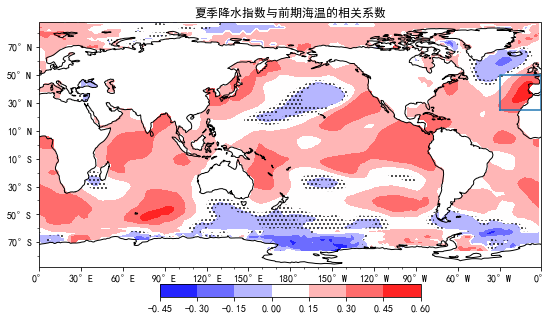

In [16]:
fig = plt.figure(figsize=(9, 6))
ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
createmap(ax)
#确定关键区的边框范围
lons=330
lone=360
lats=25
late=50
x=[lons,lons,lone,lone,lons]
y=[lats,late,late,lats,lats]
# 绘图
colorbar = ax.contourf(lon, lat, rain_sst_xg.data,cmap='bwr',transform=ccrs.PlateCarree())
plt.colorbar(colorbar, extendrect='True', orientation='horizontal', pad=0.05, fraction=0.04, shrink=1)
ax.contourf(lon, lat, rain_sst_t, levels=[-10, 0.25, 10], hatches=['...',None], zorder=1, colors="none",transform=ccrs.PlateCarree())

# 绘制边框
ax.plot(x,y,transform=ccrs.PlateCarree(central_longitude=0))
# 标题
plt.title('夏季降水指数与前期海温的相关系数')
# 保存图片
plt.savefig('data/ex7_2.png', dpi=500)

In [17]:
# 对高度场进行标准化
winhgtb = (winhgt500 - winhgt500.mean(dim='time')) / winhgt500.std(dim='time')
winhgtb

<xarray.DataArray (time: 56, lat: 73, lon: 144)>
array([[[-1.29627492, -1.29627492, -1.29627492, ..., -1.29627492,
         -1.29627492, -1.29627492],
        [-1.48642937, -1.48692696, -1.48688838, ..., -1.48891136,
         -1.48883878, -1.48952154],
        [-1.39537194, -1.38307643, -1.37109333, ..., -1.43594219,
         -1.42392598, -1.40935219],
        ...,
        [-0.15734153, -0.15186235, -0.1442232 , ..., -0.16384299,
         -0.16639543, -0.16303621],
        [-0.29376931, -0.29042637, -0.28507009, ..., -0.30746629,
         -0.30451887, -0.29850472],
        [-0.42603007, -0.42603007, -0.42603007, ..., -0.42603007,
         -0.42603007, -0.42603007]],

       [[-0.93014288, -0.93014288, -0.93014288, ..., -0.93014288,
         -0.93014288, -0.93014288],
        [-0.96531548, -0.98110358, -0.99545401, ..., -0.91895529,
         -0.93384191, -0.94883798],
        [-0.91267473, -0.94343356, -0.97190178, ..., -0.82131954,
         -0.85285665, -0.88235829],
...
        [-0.57163778, -0.5583226 , -0.54528156, ..., -0.62706496,
         -0.60732629, -0.58890706],
        [-0.53106362, -0.52376971, -0.51711851, ..., -0.55591237,
         -0.54672283, -0.53850578],
        [-0.59485825, -0.59485825, -0.59485825, ..., -0.59485825,
         -0.59485825, -0.59485825]],

       [[ 1.51440399,  1.51440399,  1.51440399, ...,  1.51440399,
          1.51440399,  1.51440399],
        [ 1.36791663,  1.36327888,  1.35846353, ...,  1.38674138,
          1.37993105,  1.37397281],
        [ 1.15116629,  1.14388144,  1.13993544, ...,  1.1793019 ,
          1.167738  ,  1.15840582],
        ...,
        [-1.03955628, -1.06520807, -1.09019816, ..., -0.96048153,
         -0.98846283, -1.01399333],
        [-0.87499279, -0.88647805, -0.89879829, ..., -0.83976336,
         -0.8526236 , -0.86341993],
        [-0.87015801, -0.87015801, -0.87015801, ..., -0.87015801,
         -0.87015801, -0.87015801]]])
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1961-12-31 ... 2015-12-31
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [18]:
# 夏季降水指数与前期冬季hgt 500hPa 的相关系数
rain_hgt_xg = xiangguan(rainzhi, winhgtb)
rain_hgt_xg

<xarray.DataArray (lat: 73, lon: 144)>
array([[ 0.05978372,  0.05978372,  0.05978372, ...,  0.05978372,
         0.05978372,  0.05978372],
       [ 0.06990541,  0.0676043 ,  0.06534816, ...,  0.07689391,
         0.07458552,  0.07237227],
       [ 0.06243685,  0.05873899,  0.05529392, ...,  0.07351926,
         0.0696769 ,  0.06604631],
       ...,
       [-0.18078087, -0.18378078, -0.18690795, ..., -0.17237849,
        -0.17512475, -0.17783867],
       [-0.14422398, -0.14560053, -0.14708568, ..., -0.13995769,
        -0.14133252, -0.14268531],
       [-0.14066733, -0.14066733, -0.14066733, ..., -0.14066733,
        -0.14066733, -0.14066733]])
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [19]:
# t检验
rain_hgt_t=tjianyan(rain_hgt_xg,56)
rain_hgt_t

<xarray.DataArray (lat: 73, lon: 144)>
array([[0.44010603, 0.44010603, 0.44010603, ..., 0.44010603, 0.44010603,
        0.44010603],
       [0.51495755, 0.49792726, 0.48123759, ..., 0.56673049, 0.54962032,
        0.53322368],
       [0.45971223, 0.43238824, 0.40694829, ..., 0.54172001, 0.51326601,
        0.48640128],
       ...,
       [1.35071788, 1.37390881, 1.39812589, ..., 1.28596794, 1.30709838,
        1.32801098],
       [1.07102298, 1.08146569, 1.0927395 , ..., 1.03869815, 1.04910842,
        1.05935785],
       [1.04407084, 1.04407084, 1.04407084, ..., 1.04407084, 1.04407084,
        1.04407084]])
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

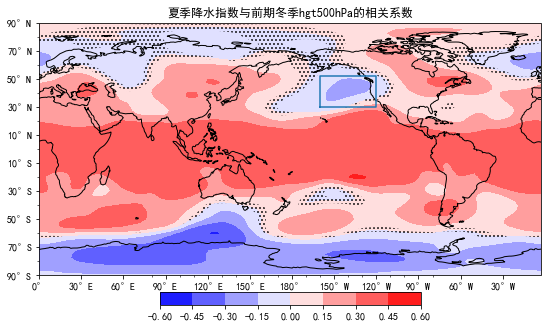

In [20]:
lat = rain_hgt_xg.lat.data
lon = rain_hgt_xg.lon.data
fig = plt.figure(figsize=(9, 6))
ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
createmap(ax)
#确定关键区的边框范围
lons=200
lone=240
lats=30
late=52
x=[lons,lons,lone,lone,lons]
y=[lats,late,late,lats,lats]
# 绘图
colorbar = ax.contourf(lon, lat, rain_hgt_xg.data,cmap='bwr', transform=ccrs.PlateCarree())
plt.colorbar(colorbar, extendrect='True', orientation='horizontal', pad=0.05, fraction=0.04, shrink=1)
ax.contourf(lon, lat, rain_hgt_t, levels=[-10, 0.25, 10], hatches=['...',None], zorder=1, colors="none",transform=ccrs.PlateCarree())
# 绘制边框
ax.plot(x,y,transform=ccrs.PlateCarree(central_longitude=0))
# 标题
plt.title('夏季降水指数与前期冬季hgt500hPa的相关系数')
# 保存图片
plt.savefig('data/ex7_3.png', dpi=500)

# 海温关键区的范围选取 [25°N-50°N，330-360]
# hgt关键区的范围选取 [30°N-52°N，200-240]

In [21]:
# 海温指数
sstzhi=winsstb.loc[:,50:25,330:360].mean(dim=['lat','lon'])
# hgt指数
hgtzhi=winhgtb.loc[:,52:30,200:240].mean(dim=['lat','lon'])

In [22]:
rainzhi

<xarray.DataArray 'pre' (year: 56)>
array([-1.3586963 ,  0.46026823, -0.8027143 , -0.4269009 , -0.14564823,
       -1.849777  , -1.1787248 ,  0.02829293,  1.4162719 , -0.3287592 ,
       -1.2173566 , -1.6182997 , -0.24412419, -0.32341954,  0.20246024,
       -0.8922324 ,  0.43663573, -2.2319322 ,  0.07966333,  1.9087536 ,
       -1.2167226 ,  1.0424433 ,  1.061591  , -0.19519861, -1.3718699 ,
       -0.519379  ,  0.40829757, -0.7199583 ,  0.16990325, -0.8979458 ,
        0.3974419 , -0.7862656 ,  1.1956921 , -0.18762189,  0.72444475,
        1.9508308 , -0.04736393,  2.0654085 ,  1.8425456 ,  0.46367902,
       -0.779068  ,  0.8803384 , -0.6182399 , -0.39207235, -0.22804157,
       -0.96259254,  0.6476939 ,  0.52858835, -0.38250312,  0.687767  ,
        0.20296547, -0.31684557, -0.5995461 ,  1.3217157 ,  1.7039237 ,
        1.0122062 ], dtype=float32)
Coordinates:
  * year     (year) int64 1961 1962 1963 1964 1965 ... 2012 2013 2014 2015 2016

In [23]:
X=np.zeros((len(rainzhi),3))
Y=rainzhi.data
X[:,0]=1
X[:,1]=sstzhi
X[:,2]=hgtzhi

In [24]:
Y

array([-1.3586963 ,  0.46026823, -0.8027143 , -0.4269009 , -0.14564823,
       -1.849777  , -1.1787248 ,  0.02829293,  1.4162719 , -0.3287592 ,
       -1.2173566 , -1.6182997 , -0.24412419, -0.32341954,  0.20246024,
       -0.8922324 ,  0.43663573, -2.2319322 ,  0.07966333,  1.9087536 ,
       -1.2167226 ,  1.0424433 ,  1.061591  , -0.19519861, -1.3718699 ,
       -0.519379  ,  0.40829757, -0.7199583 ,  0.16990325, -0.8979458 ,
        0.3974419 , -0.7862656 ,  1.1956921 , -0.18762189,  0.72444475,
        1.9508308 , -0.04736393,  2.0654085 ,  1.8425456 ,  0.46367902,
       -0.779068  ,  0.8803384 , -0.6182399 , -0.39207235, -0.22804157,
       -0.96259254,  0.6476939 ,  0.52858835, -0.38250312,  0.687767  ,
        0.20296547, -0.31684557, -0.5995461 ,  1.3217157 ,  1.7039237 ,
        1.0122062 ], dtype=float32)

# 多元回归 回归系数 b 计算公式
$b=(X^TX)^{-1}X^Ty$

In [25]:
def duob(X,Y):
    temp=np.linalg.inv(np.dot(X.T,X))
    temp=np.dot(temp,X.T)
    b=np.dot(temp,Y)
    return b

In [26]:
b=duob(X,Y)
b

array([ 4.25082233e-08,  5.93186289e-01, -2.94609137e-01])

# 多元回归方程
y=b[0]+b[1]sstzhi+b[2]hgtzhi

# 交叉检验
![CV](data/MLCV.jpg)


In [27]:
# 对于模型  y=b0+b1x1+b2x2 剔除一年当作测试集，其他年份的数据用于计算回归系数 ，测试集用于检测回归系数计算完之后的模型的回归效果
# 用于存放真实y 和回归 y
E=[]
# 用于选取数据
for i in range(len(rainzhi)):
    bo=np.bool_(np.zeros(len(rainzhi))+1)
    bo[i]=False
    X1=X[bo,:]
    Y1=Y[bo]
    b1=duob(X1,Y1)
    # 建立模型 y=b[0]+b[1]sstzhi+b[2]hgtzhi 并把测试数据放进去得到回归y
    E.append(Y[i]-(b1[0]*X[i,0]+b1[1]*X[i,1]+b1[2]*X[i,2]))

In [28]:
aveE=np.mean(E)

In [29]:
aveE

0.003966787660967823

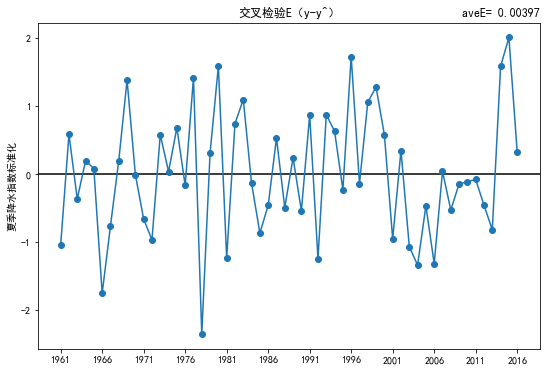

In [30]:
fig=plt.figure(figsize=(9,6))
ax=fig.subplots(1,1)
# 标题
ax.set_title('交叉检验E（y-y^）')
ax.set_title('aveE= '+ str(round(aveE,5)),loc='right')
# 绘图
ax.axhline(y=0,color='k')
ax.plot(rainzhi.year,E,marker='o')
# 刻度
ax.set_xticks(np.arange(1961, 2017, 5))
ax.set_ylabel('夏季降水指数标准化')
# 保存图片
plt.savefig('data/ex7_4.png',dpi=500)

In [31]:
# 独立试报(2000-2016)
# 个人理解 先拿1961-1999年计算回归系数，回归2000年，然后拿1961-2000计算回归系数，回归2001年
# 存放独立试报的值
Ypre=[]
for i in range(39,56,1):
    b2=duob(X[0:i,:],Y[0:i])
    Ypre.append(b2[0]+b2[1]*X[i,1]+b2[2]*X[i,2])

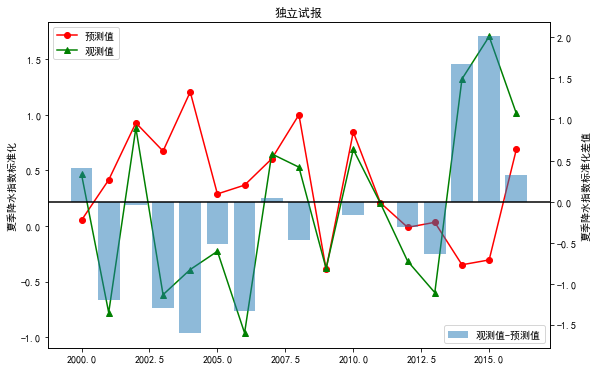

In [32]:
fig=plt.figure(figsize=(9,6))
ax=fig.subplots(1,1)
# 标题
ax.set_title('独立试报')

ax.plot(np.arange(2000,2017,1),Ypre,color='red',marker='o',label='预测值')
ax.plot(np.arange(2000,2017,1),Y[39:],color='green',marker='^',label='观测值')
ax.legend()

ax1=ax.twinx()
ax1.bar(np.arange(2000,2017,1),Y[39:]-Ypre,label='观测值-预测值',alpha=0.5)
ax1.axhline(y=0,color='black')

ax.set_ylabel('夏季降水指数标准化')
ax1.set_ylabel('夏季降水指数标准化差值')
ax1.legend(loc='lower right')

# 保存图片
plt.savefig('data/ex7_5.png',dpi=500)